In [12]:
%%bash
pip install smbprotocol

In [13]:
# Imports
import numpy as np
import pandas as pd
import smbclient
import os
import tempfile

In [14]:
smb_server_ip = os.environ['SMB_SERVER_IP']
smb_server_port = int(os.environ['SMB_SERVER_PORT'])
smb_username = os.environ['SMB_USERNAME']
smb_password = os.environ['SMB_PASSWORD']
smb_share_name = os.environ['SMB_SHARE_NAME']

# Set the SMB client configuration with the provided credentials
smbclient.ClientConfig(username=smb_username, password=smb_password)

def download_dataframe_from_smb_server(remote_file_path):
    # Create the full remote path
    remote_path = f"\\\\{smb_server_ip}\\{smb_share_name}\\{remote_file_path}"

    # Download the compressed CSV file from the SMB share
    with tempfile.NamedTemporaryFile(mode='w+b', suffix='.csv.gz', delete=False) as temp_file:
        with smbclient.open_file(remote_path, mode='rb') as remote_file:
            temp_file.write(remote_file.read())
        temp_file_path = temp_file.name

    # Load the temporary compressed CSV file into a pandas DataFrame
    df = pd.read_csv(temp_file_path, compression='gzip')

    # Delete the temporary file
    os.unlink(temp_file_path)

    return df

# Download term, bigram, trigram and 4 gram dataframes from the SMB share for both amazon and apple
apple_term_df = download_dataframe_from_smb_server('apple_term_df_compressed.csv.gz')
apple_bigram_df = download_dataframe_from_smb_server('apple_bigram_df_compressed.csv.gz')
apple_trigram_df = download_dataframe_from_smb_server('apple_3_gram_df_compressed.csv.gz')
apple_4gram_df = download_dataframe_from_smb_server('apple_4_gram_df_compressed.csv.gz')

amazon_term_df = download_dataframe_from_smb_server('amazon_term_df_compressed.csv.gz')
amazon_bigram_df = download_dataframe_from_smb_server('amazon_bigram_df_compressed.csv.gz')
amazon_trigram_df = download_dataframe_from_smb_server('amazon_3_gram_df_compressed.csv.gz')
amazon_4gram_df = download_dataframe_from_smb_server('amazon_4_gram_df_compressed.csv.gz')


In [31]:
def save_dataframe_to_smb_server(df, remote_file_path):
    # Create a temporary file to store the compressed CSV
    with tempfile.NamedTemporaryFile(mode='w+', suffix='.csv.gz', delete=False) as temp_file:
        df.to_csv(temp_file.name, index=False, compression='gzip')
        temp_file_path = temp_file.name

    # Create the full remote path
    remote_path = f"\\\\{smb_server_ip}\\{smb_share_name}\\{remote_file_path}"

    # Upload the temporary compressed CSV file to the SMB share
    with open(temp_file_path, 'rb') as local_file:
        with smbclient.open_file(remote_path, mode='wb') as remote_file:
            remote_file.write(local_file.read())

    # Delete the temporary file
    os.unlink(temp_file_path)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD

def plot_explained_variance(dataframes, titles, n_components=100, threshold=0.01):
    plt.figure(figsize=(10, 6))

    for df, title in zip(dataframes, titles):
        df_without_label = df.iloc[:, :-1]
        svd = TruncatedSVD(n_components=n_components)
        svd.fit(df_without_label)
        explained_variance = np.cumsum(svd.explained_variance_ratio_)
        differences = np.diff(explained_variance)
        elbow_point = np.argmax(differences < threshold) + 1

        plt.plot(range(1, n_components + 1), explained_variance, label=title)
        plt.plot(elbow_point, explained_variance[elbow_point], 'kx')
        svd_optimal = TruncatedSVD(n_components=elbow_point)
        reduced_data = svd_optimal.fit_transform(df_without_label)
        reduced_df = pd.DataFrame(reduced_data)
        reduced_df['label'] = df.iloc[:, -1]

        save_dataframe_to_smb_server(reduced_df, f"{title}_reduced.csv.gz")

    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

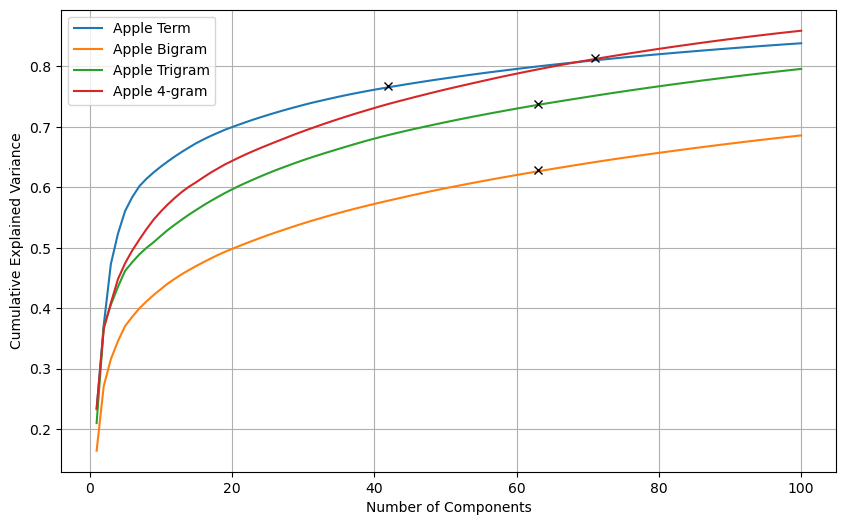

In [35]:
# Plot the explained variance for the term, bigram, trigram and 4 gram dataframes for both amazon and apple
plot_explained_variance([apple_term_df, apple_bigram_df, apple_trigram_df, apple_4gram_df], ['Apple Term', 'Apple Bigram', 'Apple Trigram', 'Apple 4-gram'], threshold=0.002)

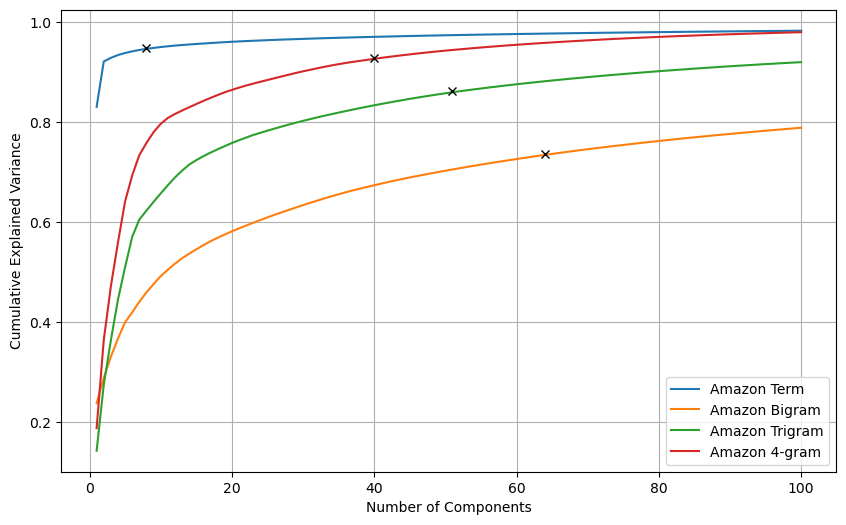

In [36]:
plot_explained_variance([amazon_term_df, amazon_bigram_df, amazon_trigram_df, amazon_4gram_df], ['Amazon Term', 'Amazon Bigram', 'Amazon Trigram', 'Amazon 4-gram'], threshold=0.002)